# PAPERS DECONSTRUCTED
## Title: Greedy Function Approximation: A Gradient Boosting Machine
### Authors: Jerome H. Friedman
Link: https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full

*Papers deconstructed* are a result of my frustration when reading papers and walking away with a fuzzy understanding. By folding in commentary, Python code implementations, I aim to make the paper much more understandstable to all. I also find it really fun :)

# Executive Summary

Most machine learning algorithms by finding the best parameter values for a loss function and training dataset. Gradient descent is typically used to solve this. This works (roughly) as follows:

(1) Fetch the true value for the given training example

(2) Compute a predicted value for the given training example

(3) Compute the loss given the true value and predicted value

(4) Compute the gradient of the loss with respect to the parameters

In this paper step (2) is left as an unknown and the gradient is _directly_ learned from data instead. This is done by setting up a supervised machine learing problem of the following:

Training Dataset = $\{ (\tilde{y_i}, x_i) \}_i^N$ 

where $\tilde{y_i}$ is the gradient of the loss with respect to the prediction value evaluated at the _previous_ prediction value. Learning the gradient is repeated at each step.

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.base import clone
import numpy as np

# Full Paper

# Abstract

> <i>Function estimation/approximation is viewed from the perspective of
numerical optimization in function space, rather than parameter space</i>

Instead of optimizing for a parameter value (like the slope value in linear regression), we are optimizing for a function directly. This is unusual. ML algorithms are typically designed to optimize over parameter values, not functions directly. We typically calculate something like $\frac{\partial J}{\partial \theta}$ (where J is the cost function and $\theta$ is a parameter value) but here we are calculating something like $\frac{\partial J}{\partial f(x)}$. We take a derivative with respect to a function!

> <i>A connection is made between stagewise additive expansions and steepest descent minimization.</i>

_steepest-descent minimization_ is not the same as _gradient descent_. See this <a href="https://stats.stackexchange.com/a/322177/30545">link</a>. The link also includes a <a href="http://www.math.usm.edu/math/lambers/mat419/lecture10.pdf">reference</a> that's helpful. Steepest-descent minimization is a special case of gradient descent. Gradient descent is using knowledge of the gradient to choose where to step next. But _how_ you take a step, leads you to specific algorithms (such as steepest-descent).

In steepest-descent, the goal is to find a $\alpha$ that minimizes $g$:

$g({\alpha}) = f(x_{t-1} - \alpha \nabla f(x_{t-1})) \;\;\; \alpha \ge 0$

I'm not a numerical specialist, but there's a tradeoff here. While we are exact (as opposed to using a fixed step size), this requires solving an additional optimization problem at each step. I would think the tradeoffs are problem specific.

> <i>A general gradient descent “boosting” paradigm is
developed for additive expansions based on any fitting criterion.</i>

Additive models are models where can break the model into a sum of models:

f(x) = $\sum_i f_i(x)$

Stagewise (as opposed to _stepwise_) means we can't go back and edit. Each 'stage' freezes all previous terms. Section **3.3.3 Forward-Stagewise Regression** <a href="https://web.stanford.edu/~hastie/ElemStatLearn/">The Elements of Statistical Learning</a> is helpful.

The boosting paradigm mentioned is a reference to Freund and Schapire's <a href="https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf">paper</a> in the late 90s that introduced the AdaBoost algorithm. The idea of boosting is to build a many models in a sequence. Each model learns from the mistakes from the previous model.

By "any fitting criterion" means that this works (essentially) for any loss function.

> <i>Specific algorithms are presented for least-squares, least absolute deviation, and
Huber-M loss functions for regression, and multiclass logistic likelihood
for classification</i>

Let's show what each of these losses look like mathematically and implemented in code:

In [2]:
# First, we setup some data to demonstrate each function with

# True function
f_star = lambda x: x**2

# Estimated function
# (we introduce a little bit of error)
f = lambda x: (x + 0.1)**2

# Points to evaluate over
x = np.arange(0, .5, step=0.05)

**least-squares loss**

$l(y, f) = \frac{1}{2} (y - f)^2$

In [3]:
def least_squares(y_true, y_pred):
    loss = .5 * (y_true - y_pred)**2
    return loss

least_squares(f_star(x), f(x))

array([5.00e-05, 2.00e-04, 4.50e-04, 8.00e-04, 1.25e-03, 1.80e-03,
       2.45e-03, 3.20e-03, 4.05e-03, 5.00e-03])

**least-absolute deviation**

$l(y, f) = |y - f|$

In [4]:
def least_absolute_deviation(y_true, y_pred):
    loss = np.abs(y_true - y_pred)
    return loss

least_absolute_deviation(f_star(x), f(x))

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

**huber-m**

if $|y - f| \le \delta$ then:

$l(y, f) =  \frac{1}{2} (y - f)^2$

else:

$l(y, f) =  \delta(|y - f| - \frac{\delta}{2})$

This is the first time I had across Huber loss. The paper can be found <a href="https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full">here</a>.

The "m" I believe comes from the term "m-estimator". I _think_ the m means "maximum likelihood type" estimator. See <a href="https://www.statisticalconsultants.co.nz/blog/m-estimators.html">here</a>. It comes from robust statistical methods. Something I myself would need to learn more about. This function acts as a switch. When the error gets too high it acts as a switch to a loss that doesn't penalize as heavily.

In [100]:
def huber(y_true, y_pred, delta=5.):
    z = y_true - y_pred
    z_abs = np.abs(z)
    loss = np.where(z_abs <= delta, .5 * z**2, delta * (z_abs - delta/2.))
    return loss

huber(f_star(x), f(x))

array([5.00e-05, 2.00e-04, 4.50e-04, 8.00e-04, 1.25e-03, 1.80e-03,
       2.45e-03, 3.20e-03, 4.05e-03, 5.00e-03])

**multi-class logistic likelihood**

$l(y, f) = - \sum_k^{\text{n_classes}} y_k \text{log} \, p_k$

The variable k is to iterate over each class. $y_k$ is either 0/1 and $p_k$ is your models outputted "probability" for that class. I put the probability in quotes because you don't always get good probabiity estimates in practice.

We can write down the special case of a binary label (0/1):

$l(y, f) = -  \big( y_k \text{log} \, p_k + (1 - y_k) \text{log} \, (1 - p_k) \big)$

This acts as a switch. When the label is 1 we get:

$l(y, f) = - \text{log} \, p_k$

When the label is 0 we get:

$l(y, f) = - \text{log} \, (1 - p_k)$

In [101]:
def logistic_likelihood(y_true, y_pred, delta):
    loss = -(y_true * np.log(y_pred) + (1. - y_true) * np.log(1 - y_pred))
    return loss

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_true = np.random.randint(0, 2, len(x))

# Pass through sigmoid to get a number
# between 0 and 1. Acts like a probability
y_pred = sigmoid(f(x))

logistic_likelihood(y_true, sigmoid(f(x)), delta=0.1)

array([0.69815968, 0.68196046, 0.67334717, 0.72488538, 0.73915934,
       0.75627179, 0.77634377, 0.79951423, 0.57593942, 0.55329211])

This is a function we use

> <i>Special enhancements are derived for the particular case
where the individual additive components are regression trees, and tools
for interpreting such “TreeBoost” models are presented.</i>

They exploit the special case when the additive model is comprised of decision trees--which they then call "TreeBoost". Note that <a href="https://xgboost.readthedocs.io/en/stable/">XGBoost</a> by default uses TreeBoost.

> <i>Gradient boosting of regression trees produces competitive, highly robust, interpretable procedures for both regression and classification, especially appropriate for
mining less than clean data. Connections between this approach and the
boosting methods of Freund and Shapire and Friedman, Hastie and Tibshirani are discussed.</i>

Lastly, they mention how all this ties in with the Adaboost algorithm (which introduced the idea of boosting).

# 1 Function Estimation

> <i>In the function estimation or "predictive learning" problem, one has a system consisting of a random "output" or "response" variable y and a set of random "input" or "explanatory" variables $\bf{x} = \{x_1, ..., x_n\}$</i>

You are given labeled data (i.e., training data)

><i>Using a “training” sample $\{y_i, \bf{x_i}\}_{i}^{N}$
1 of known $(y, \bf{x})$-values, the goal is to
obtain an estimate or approximation $\hat{F}(\bf{x})$, of the function $F^{*}(x)$ mapping $\bf{x}$ to y, that minimizes the expected value of some specified loss function
$L(y, F(\bf{x}))$ over the joint distribution of all ($y, \bf{x})$-values,
<br/>
<br/>
$F^* = \text{argmin}_F E_{y, \bf{x}} L(y, F(\bf{x})) = \text{argmin}_F E_x [E_y(L(y, F(\bf{x}))) | \bf{x}]$
</i>

$F^{*}(x)$ is the true function. Unknown in practice (unless you are simulating data). But we can observe how inputs are relate to the outputs via labeled data. $F(x)$ is the function we learn from data. But to do learning, we need a measure of how good we are doing. Hence, the loss function:

$L(y, F(x)) = L(F^{*}(x), F(x))$.

A smaller loss value is better--less prediction error. We must compute the loss over each $(\vec{x},y)$ pair. When the losses can be computed in parallel, we call that a univariate loss function. The opposite of this are multivariate losses. For example, see work done by Thorsten <a href="https://www.cs.cornell.edu/people/tj/publications/joachims_05a.pdf">here</a>. Multivariate losses are used (for example) when designing a ranking algorithm.

We want to summarize all these losses. A way to do this is to take a sum or an average. Typically the average loss is used.

To get the form you see in this paper, I actually answered this many years ago <a href="https://math.stackexchange.com/a/623473/118474">here</a>. But here it is again:

$\text{Expected Loss} = \int_x \int_y L(y, F(x)) P(x, y) \, dx dy$

By Bayes' theorem: $P(x, y) = P(x) P(y | x)$

Let's substitute

$\int_x \int_y L(y, F(x))  P(x) P(y | x) \, dx dy$

We can rearrange:

$\int_x P(x) \big( \int_y L(y, F(x)) P(y | x) \, dy \big) dx$

And $\int_y L(y, F(x)) P(y | x) dy$ is by definition $E_y [L(y, F(x) | x]$

so 

$\int_x P(x) \big( E_y [L(y, F(x) | x] \big) dx$

But this is again, another expectation. So now we get:

$E_x[E_y [L(y, F(x) | x]]$

Hence:

$F^* = {\text{argmin}}_F \, E_{xy}[L(y, F(x))] = {\text{argmin}}_F \, \int_x \int_y P(x, y) L(y, F(x)) \, dx dy$

> <i>Frequently employed loss functions $L(y, F)$ include squared-error $(y − F^2)$ and absolute error $|y − F|$ for $y \in R^1$ (regression) and negative binomial loglikelihood, $log(1 + e^{−2yF}$, when $y \in \{−1, 1\}$ (classification).</i>

This is telling us specific cases of what $L(y, F(X))$ can be.

> <i>A common procedure is to restrict $F(\bf{x})$ to be a member of a parameterized class of functions $F(\bf{x}; \bf{P})$, where $P = \{P_1, P_2, ...\}$ is a finite set of parameters whose joint values identify individual class members.</i>

I will give a concrete example here. Take simple linear regression. Its takes the form of:

$F(x) = b + mx$

To rewrite in the notation just given:

$F(x; \bf{P} ) = p_1 + p_2 x$

So $P = \{p_1, p_2\}$. Note that we fixed the function (basically) and now seek what the values of $b$ and $m$ are. I say basically because technically, each new set of parameters map out a different function, but the models _structure_ remains the same (i.e., linear form).

> <i>In this article we focus on "additive" expansions of the form $F(\bf{x}; \{\beta_m, \bf{a}_m\}_1^M) = \sum_m \beta_m h(\bf{x}; \bf{a}_m)$</i>

This additive expansion is saying, we have $m$ models that get added together. Each multiplied by a weight of $\beta_m$. (The $m$ denotes which model we are referring to--there are $m$ of them). Each model is denoted as $h(x; a_m)$. The $a_m$ is telling us each model itself has a set of parameters that need to be estimated from data. And these models do not share parameters (would be interesting to think of use-cases where parameter sharing might be beneficial). Also, I see no reason why each model must keep the same structural form (decision tree vs naive bayes). But in practice, and even in this paper, $h(x; a_m)$ is left to be a decision tree. In the package XGBoost for example, $h(x; a_m)$ is referred to as the _booster_.

> <i>The (generic) function $h(\bf{x}, a)$ in (2) is usually a simple parameterized function of the input variables $\bf{x}$, characterized by parameters $\bf{a} = \{a_1, a_2, ... \}$. The individual terms differ in the joint values $a_m$ chosen for these parameters.</i>

Yep. Each model will estimate $a_m$ to have different values than the others.

>  <i>Such expansions (2) are at the heart of many function approximation methods such as neural networks, radial basis functions, wavelets, and support vector machines. Of special interest here is the case where each of the functions $h(\bf{x}; \bf{a}_m)$ is a small regression tree, such as those produced in CART. For a regression tree the parameters $\bf{a}_m$ are the splitting variables, split locations, and the terminal node means of the individual trees.</i>

They mention a bunch of ML models where this type of additive model is applicable. But the one of interest here, is the regression tree (i.e., decision tree). To parameterize this tree, at each node we have to choose a variable and a split point for that variable. So here they are saying that $a_m$ will denote the feature chosen for each node and its split point. We can count the number of parameters. At depth $l$ we will have $2^l$ nodes. So there are:

$\text{number of decision nodes} = \sum_l^{D} 2^l$ where $D$ is the max depth

$\sum_l^{D} 2^l = 2^{D + 1} - 1$ (see <a href="https://math.stackexchange.com/a/1990146/118474">proof</a>)

And two parameters for each node (which variable and its split point):

$ 2 * (2^{D + 1} - 1) = 2^{D + 2} - 2$

I've built models in practice with depths reaching over 10 (even up to 15). So with $D = 15$ we get $131070$ parameters for a single decision tree!

In [3]:
def get_num_params(max_depth):
    n_param = (2**(max_depth + 2) - 2)
    n_param_from_longer_calculation = 2 * sum([2**j for j in range(max_depth + 1)])
    
    # Evidence for proof
    assert n_param == n_param_from_longer_calculation
    
    return n_param

get_num_params(max_depth=15)

131070

# 1.1 Numerical Optimization

> <i>In general, choosing a parameterized model $F(\bf{x}; \bf{P})$ changes the function optimization problem to one of parameter optimization
<br />
<br />
$P^* = \text{argmin}_P \Phi(\bf{P})$
<br />
<br />
where
<br />
<br />
$ \Phi(P) = E_{y, x} L(y, F(x; P))$
<br />
<br />
and then
<br />
<br />
$ F^*(x) = F(x; P^*)$</i>

Yes. In linear regression (for example) we use the loss function of least squares to find the best set of parameters. But the key here is that we fix the structure of the model and optimize over the parameters.

> <i>For most $F(x; P)$ and L, numerical optimization methods must be applied to solve $P^* = \text{argmin}_P \Phi(\bf{P})$. This often involves expression the solution for the parameters in the form
<br />
<br />
$P^* = \sum_{m=0}^M p_m$
<br />
<br />
where $p_0$ is the an initial guess and $\{ p_m\}_1^M $ are successive increments ("steps" or "boosts"), each based on the sequence of preceding steps. The precription for computing each step $p_m$ is defined by the optimization method.</i>

in neural networks, we leverage gradient descent. The weight parameters get updated at each step by adding a value to them. Sp the final weights learned are a sum of the weight updates from each step. That is: 

$\vec{w}_{final} = \sum_i w_i$

We start with an initial guess of parameters ($w_0$) and increment after each step. In the cast of boosting, it's called a boost. But it can really be thought of as a step.

# 1.2 Stepest-descent

> <i>Steepest-descent is one of the simplest of the frequently used numerical minimization methods. It defines the increments $\{p_m\}_i^M$ as follows. FIrst the current gradient $g_m$ is computed
<br />
$g_m = \{g_{jm}\} = \{ [\frac{\partial \phi(P)}{\partial P_j}]_{P = P_{m -1}}\}$
<br />
where
<br />
$P_{m-1} = \sum_{i = 0}^{m - 1}p_i$
<br />
The step is taken to be
<br />
$p_m = -\rho_m g_m$
<br />
where
<br />
$\rho_ = \text{argmin}_{\rho} \Phi (P_{m -1} - \rho g_m)$
<br />
The negative gradient $-g_m$ is said to define the "steepest-descent" direction and (5) is called the "line search" along that direction.</i>

Rememeber, steepest-descent is a special case of gradient descent where the step size ($\rho$) is taken such that the following function is at its lowest point:

$\Phi (P_{m -1} - \rho g_m)$

For a neural network, $P_{m -1}$ would the weight vector before the update is applied. 

We take the gradient of our loss function with respect to the parameter in context (the $jth$ parameter) for the _mth_ model.

💻 Let's clear this up with some code. For examples sake, I'm going to use a brute force approach and try a bunch of values for the line search.

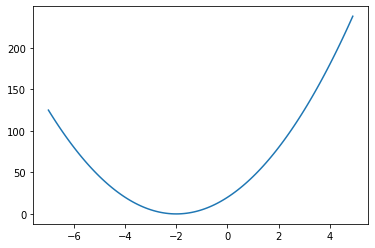

In [6]:
# The function we want to minimize
def f(w):
    return 5*(w + 2)**2

# It's gradient
def grad_f(w):
    return 2 * (w - 5)

w = np.arange(-7, 5, step=.1)

fig, ax = plt.subplots()
ax.plot(w, f(w))

In [7]:
def do_steepest_descent_step(w, f, grad_f, step_size=1.,
                             steepest_descent=False):
    
    # Evaluate current parameter at gradient
    grad = grad_f(w)
    print(f'Grad value: {grad}')
    
    # Brute force approach:
    # try a vector of candidates for line search
    if steepest_descent:
        step_sizes = np.arange(0, 0.3, step=1e-5)
        y = f(w - step_sizes * grad)
        step_size = step_sizes[np.argmin(y)]
        print(f'Best step size: {step_size}')
    
    # We add ""-step_size * grad"
    # to w. So gradient descent is really
    # about adding a bunch of values
    # until we are dones just like the paper
    # points out
    
    w_new = w - step_size * grad
        
    return w_new

In [10]:
w = 10.
for i in range(10):
    print(f'Step {i + 1}')
    print(f'w_before={w}')
    w_new = do_steepest_descent_step(w, f, grad_f, steepest_descent=True)
    if w == w_new:
        print('Convergence reached!')
        break
    w = w_new
    print(f'w_after={w}')
    print('')
print(f'Final value: {w}')

Step 1
w_before=10.0
Grad value: 10.0
Best step size: 0.29999000000000003
w_after=7.0001

Step 2
w_before=7.0001
Grad value: 4.0001999999999995
Best step size: 0.29999000000000003
w_after=5.800080002

Step 3
w_before=5.800080002
Grad value: 1.6001600039999992
Best step size: 0.29999000000000003
w_after=5.32004800240004

Step 4
w_before=5.32004800240004
Grad value: 0.6400960048000801
Best step size: 0.29999000000000003
w_after=5.128025601920064

Step 5
w_before=5.128025601920064
Grad value: 0.25605120384012814
Best step size: 0.29999000000000003
w_after=5.051212801280064

Step 6
w_before=5.051212801280064
Grad value: 0.10242560256012823
Best step size: 0.29999000000000003
w_after=5.020486144768051

Step 7
w_before=5.020486144768051
Grad value: 0.04097228953610177
Best step size: 0.29999000000000003
w_after=5.008194867630116

Step 8
w_before=5.008194867630116
Grad value: 0.016389735260231575
Best step size: 0.29999000000000003
w_after=5.003278110949399

Step 9
w_before=5.003278110949399


# 2 Numerical optimiizing in function space

> <i>Here we take a "nonparametric" approach and apply numerical optimization in function space. That is we consider F(x) evaluated at each point x to be a "parameter" and seek to minimize
<br />
<br />
$\Phi(F) = E_{y,x}L(y, F(x)) = E_x[E_y [L(y, F(x) | x]]$
<br />
<br />
or equivalently
<br />
<br />
$\Phi(F(x)) = E_y [L(y, F(x)) | x]$
<br />
<br />
at each individual x, directly with respect to F(x). 
</i>

If we treat each $F(x)$ as a parameter, there will be as many parameters as there are unique x values. In practice, you will only be given a finite number of parameter observations (the training data).

This is similar to instance-based methods (you store the data and use at runtime) in ML. For example, in the nearest neighbor model, you store the data and when picking a point, find the 5 nearest neighbors for example. The data itself ARE the parameters of the model. But the parameters do not need to be estimated, they are just given. But this paper is not using an instance-based approach, we still want to estimate the parameter at each point. This is the only way we can make predictions for the parameters not observed.

> <i>In function space there are an infinite number of such parameters, but in data sets (discussed below) only a finite number $\{F(x_i)\}_i^N$ are involved. Following the numerical optimization paradigm we take the solution to be
<br />
<br />
$F^*(x) = \sum_m f_m(x)$
<br />
<br />
where $f_0(x)$ is an initial guess, and ${f_m(x)}_1^M$ are incremental functions ("steps" or "boosts") defined by the optimization method.
</i>

We only have as many parameters as training examples. If are treating the function as a parameter, taking the sum approach like how parameters are estimated makes sense. In the parameter approach, we end up with a final vector of parameters that is then used in our model (which has a fixed structure). Here, we actually end up with the model outputs instead.

So this is basically an exercise in notation. Everwhere there is a $p$ just replace with $f_m$. But this raises a major practical issue: what happens when you want to get an output for an $x$ not in the training dataset?

> <i>For steepest-descent
<br />
<br />
$f_m(x) = -\rho_m g_m(x)$
<br />
<br />
with
<br />
<br />
$g_m(x) = [\frac{\partial \phi(F(x))}{\partial F(x)}]_{F(x) = F_{m - 1}(x)} = [\frac{\partial E_y [L(y, F(x) | x]}{\partial F(x)}]_{F(x) = F_{m - 1}(x)}$
<br />
<br />
and
<br />
<br />
$F_{m - 1}(x) = \sum_{i=0}^{m-1} f_i(x)$
<br />
<br />
Assuming sufficient regularity that one can interchange differentiation and integration, this becomes
<br />
<br />   
$g_m(x) = E_y[\frac{\partial L(y, F(x))}{\partial F(x)}]_{F(x) = F_{m-1}(x)}$
<br />
<br />  
The multiplier $\rho_m$ in (6) is given by the line search
<br />
<br /> 
$\rho_m = \text{argmin}_{\rho_m} E_{y, x} L(y, F_{m - 1}(x) - \rho_m g_m(x))$
</i>

Here, $\rho_m$ is calculated with the line search (like the naive implementation we did earlier). In a package like XGBoost, it's known as the "eta" parameter. AFAIK, it's a hyperparameter this is constant across all "boosts".

Recall that $E_y [L(y, F(x)) | x]$ is $\int_y L(y, F(x)) P(y | x) dy$. For a given $x$ then, for the true underlying function, what is the probability of y given that x? This must be 1 when y is correct, and 0 otherwise. So this really just picks out $L(y, F(x))$

# 3 Finite data

> <i>This nonparametric approach breaks down when the joint distribution of (y, x) is estimated by a finite data sample $\{y_i, x_i\}_i^N$. In this case $E_y[. | x]$ cannot be estimated accurately by its data value at each $x_i$, and even if it could, one would like to estimate $F^*(x)$ at x values other than the training sample points. Strength must be borrowed from nearby data points by imposing smoothness on the solution. One way to do this is to assume a parameterized form such as (2) and do parameter optimization as discussed in Section 1.1 to minimize the corresponding data based estimate of expected loss
<br />
<br />
$\{ \beta_m, a_m\}_i^M = \text{argmin}_{\beta_m, \alpha_m} \sum_{i=1}^N L \big( y_i, \sum_m \beta_m h(x_i; a_m) \big)$
</i>

This means we are back to assuming a parameterized model! And the model assumed here, is an additive one. Also, this optimization is done jointly--which gets harder and harder to do as the number of terms grows and the model complexity grows.

> <i>In situations where this is infeasible one can try a "greedy-stagewise" approach. For $m = 1, 2, ..., M$
<br />
$(\beta_m, \alpha_m) = argmin_{\beta, a} \sum_i^N L(y_i, F_{m-1}(x_i) + \beta h(x_i; a)$
<br />
and then
<br />
$F_m(x) = F_{m - 1}(x) + \beta_m h(x; a_m)$</i>

So the tradeoff here is that we won't in general, obtain the correct solution. By freezing the set of parameters at each 'stage', this means we only have to learn the the weight and parameters of the given booster one at a time. It does make me wonder how much of a tradeoff this is.

> <i>Note that this stagewise strategy is different from stepwise approaches that readjust previously entered terms when new ones are added. In signal processing this stagewise strategy is called "matching pursuit" where L(y, F) is squared-error loss and the $\{h(x; a_m\}_1^M$ are called basis functions, usually taken from an over-complete wavelet-like dictionary. In machine learning, (9) (10) is called "boosting" where $y \in \{-1, 1\}$ and $L(y, F)$ is either an exponential loss criterion $e^{-yF}$ or negative binomial log-likelihood. The function h(x; a) is called a "weak learner" or "base learner", and is usually a classification tree.</i>

The "matching pursuit" algorithms arises from the paper <a href="https://www.di.ens.fr/~mallat/papiers/MallatPursuit93.pdf">Matching Pursuits with Time-Frequency Dictionaries</a>. Uforunately, not much more I can say about it at this time.

I have not studied much on the topic of sparse coding. But here's what I could gather. A vector is represented by a linear combination of a set of basis vectors (in general, no requirement these be orthogonal). When we say basis, what we mean is that each vector is UNIQUELY represented by a set of components (the coefficients in the linear sum of basis vectors). But it seems while mathematically nice, it's not always practical. It turns having the ability to represent a vector in more than one way brings benefits (I cannot articulate why at this time). This means we will need to more atoms than we need. This is where the term "over-complete dictionary" comes in. The wavelet refers to the type of $h(x; a)$ model we assume. The exponential loss is referring back to the Adaboost paper. Also, $h(x; a)$ is also called a "booster" as well.

><i>Suppose for that for a particular loss $L(y, F)$ and/or base learner $h(x; a)$ the solution to $(\beta_m, \alpha_m) = argmin_{\beta, a} \sum_i^N L(y_i, F_{m-1}(x_i) + \beta h(x_i; a)$ is difficult to obtain. Given any approximator $F_{m-1}(x)$, the function $\beta_m h(x; a_m)$ can be viewed the best greedy step towards the data based estimate of $F^*(x)$, under the constraint that the step "direction" $h(x; a_m)$ be a member of the parameterized class of functions $h(x;a)$. It can thus be regarded as a steepest-descent step under that constraint. By construction, the data based analogue of the unconstrained negative gradient
<br/>
<br/>
$-g_m(x_i) = - \big[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \big]_{F(x) = F_{m - 1}(x)}$
<br/>
<br/>
gives the best steepest-descent step direction $-g_m = \{ -g_m(x_i)\}_1^N$ in the N-dimensional data space at $F_{m-1}(x)$
</i>

What this is saying, is that we create a vector of made up N components, where a single component is $L(y_i, \hat{y_i})$. By taking the gradient of this vector, and taking a step in the opposite direction of this gradient, we are approaching a point in this space where the loss becomes a minima.

> <i>However, this gradient is only defined only at the data points $\{ x_i\}_i^N$ and cannot be generalized to other x-values. One possibility for generalization is to choose that member of the parameterized class $h(x; a_m)$ that produces $h_m = \{ h(x_i; a_m \}_{1}^N$ most parallel to $-g_m \in R^N$. This is the $h(x; a)$ most highly correlated with $-g_m(x)$ over the data distribution. It can be obtained from the solution:
<br />
<br />
$a_m = \text{argmin}_{a, \beta} \sum_i^N [-g_m(x) - \beta h(x_i; a)]^2$
</i>

Realize, we are back to a parameterized model. But what's novel here, is that are trying to learn the gradient of the loss function. The $h(x_i; a)$ is now a model that is trying to replicate the loss gradient. So this is a different type of learning. We can call this "gradient learning".

Now, because of this, a new and different cost function is introduced. Here, the author chooses least squares (but of course other cost functions can be used). By learning the gradient, this allows the model to be defined for $x$ not in the training set.



> <i>This constrained negative gradient $h(x; a_m)$ is used in place of the unconstrained one in the steepest-descent strategy. Specifically, the line search is performed
<br/>
<br/>
$\rho_m = \text{argmin}_{\rho} \sum_i^N L(y_i, F_{m - 1}(x_i) - \rho h(x_i; a_m))$
<br/>
<br/>
and the approximation updated
<br/>
<br/>
$F_m(x) = F_{m-1}(x) + \rho_m h(x; a_m)$
<br/>
<br/>
Basically, instead of obtaining the solution under a smoothness constraint, the constraint is applied to the unconstrained (rough) solution by fitting $h(x; a)$ to the "pseudo-responses" $\{ \tilde{y_i} = -g_m(x_i)\}_{i=1}^N$. This permits the replacement for the difficult function minimization problem by least-squares function minimization, followed by only a single parameter optimization based on the original criterion. Thus, for any $h(x; a)$ for this a feasible least-squares algorithm exists for solving $a_m = \text{argmin}_{a, \beta} \sum_i^N [-g_m(x) - \beta h(x_i; a)]^2$, one can use this approach to minimize any differential loss $L(y, F)$ in conjunction with forward stagewise additive modeling.
    
The uncontrained so-called "rough" solution is using the training gradient values (the value from calculating the deriative of the loss function). These values are what Friedman calls the "pseudo-responses". I mean, it's not the response value itself (which is $y$). But it's obtained after feeding our $y$ into the loss function and taking the first derivative.

><i>This leads to the following (generic) algorithm using steepest-descent.
<br />
$F_0(x) = \text{argmin}_{\rho} \sum_i^N L(y_i, \rho)$
<br />
For $m=1$ to M do:
<br />
&nbsp; &nbsp; &nbsp; &nbsp; $y_i = - \big[ \frac{\partial L(y_i, F(x_i)}{\partial F(x_i)} \big]_{F(x) = F_{m-1}(x)}$, over $i=1, N$
<br />
&nbsp; &nbsp; &nbsp; &nbsp;  $a_m = \text{argmin}_{a, \beta} \sum_i^N [\tilde{y_i} - \beta h(x_i; a)]^2$
<br />
&nbsp; &nbsp; &nbsp; &nbsp;  $\rho_m = \text{argmin}_{\rho} \sum_i^N L(y_i, F_{m-1}(x_i) + \rho h(x_i; a_m))$
<br />
&nbsp; &nbsp; &nbsp; &nbsp;  $F_m(x) = F_{m - 1}(x) + \rho_m h(x; a_m)$
<br />
</i>

💻 Let's implement this now. For the loss, we will use least squares. We will rely on JAX for computing the gradient of an arbitrary function (a loss function in our case). For those not familar with JAX, the quick summary is this: 

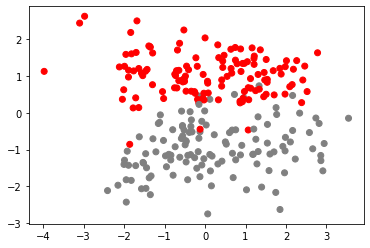

In [49]:
# First make a toy dataset to train model on
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=250,
                           n_features=2,
                           n_redundant=0,
                           random_state=3)

plt.scatter(X[:,0], X[:, 1],
            color=['red' if yi else 'gray' for yi in y])

In [51]:
from jax import grad

class GBM():
    def __init__(self,
                 loss_fn,
                 booster,
                 n_boost,
                 step_size=0.001):
        
        # Hyperparams
        self.n_boost = n_boost
        self.step_size = step_size
        self.booster = booster
        self.loss_fn = loss_fn
        
        self.grad_loss_fn = grad(loss_fn)
        
        # Set during fit
        # But set here for visibility sake
        self.prior = None
        self.boosters = []
        self.training_loss = []
    
    def fit(self, X, y):
        
        # Required for JAX
        y = y.astype('float')
        
        self.prior = np.mean(y)
                
        y_hat = np.random.normal(loc=self.prior,
                                 scale=.001,
                                 size=X.shape[0])
        
        self.training_loss = []
        
        for _ in range(self.n_boost):
            
            # Clone a model
            model = clone(self.booster)
            
            # Use JAX to calculate gradient from known values
            y_train = self.grad_loss_fn(y, y_hat).to_py()
                        
            # Build a model that learns gradient
            model.fit(X, y_train)
            
            # Predict gradient values
            grad_hat = model.predict(X)
            
            # Take a step such that loss function
            # is getting smaller
            y_hat = y_hat - self.step_size * grad_hat
            
            # Save model for future inferences
            self.boosters.append(model)
            
            # Predict what we have thus far
            y_pred = self.predict(X)
            
            self.training_loss.append(self.loss_fn(y, y_pred))
            
    def predict(self, X):
        
        y_hat = np.random.normal(loc=self.prior,
                                 scale=.01,
                                 size=X.shape[0])
        
        for booster in self.boosters:
            
            # Make a prediction
            grad_hat = booster.predict(X)
            
            # Take step
            y_hat = y_hat - self.step_size * grad_hat
            
        return y_hat

In [79]:
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_loss_fn(y, y_hat):
    y_hat = sigmoid(y_hat)
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1. - y_hat))
    return loss

model = GBM(loss_fn=logistic_loss_fn,
            booster=DecisionTreeRegressor(max_depth=1),
            n_boost=130,
            step_size=0.0001)

model.fit(X, y)
roc_auc_score(y, model.predict(X))

0.40616999487967226

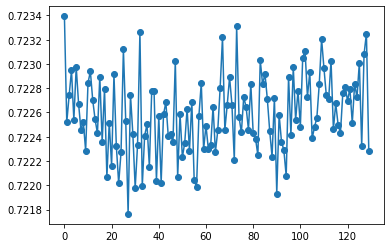

In [80]:
plt.plot(range(len(model.training_loss)), model.training_loss, marker='o')

In [58]:
# Compare against one decision tree
model_b = DecisionTreeRegressor(max_depth=1)
model_b.fit(X, y)
roc_auc_score(y, model_b.predict(X))

0.9558371735791091

> <i>Note that any fitting criterion that estimates conditional expecation (given x) could in principle be used to estimate the (smoothed) negative gradient at line 4 of Algorithm 1. Least-squares (11) is a natural choice owing to the superior computational properties of many least-squares algorithm

Yes. It's really just learning the gradient of the loss. So any cost function will work. Least-squares is a reasonable default IMHO.

><i> In the special case where $y \in \{-1, 1\}$ and the loss function $L(y, F)$ depends on y and F only through their product $L(y, F) = L(yF)$, the analogy of boosting (9), (10) to steepest-descent minimization has been noted in the machine learning literature. Duffy and Hemlbold elegantly exploit this analogy to motivate their GeoLev and and GeoArc procedures. The quantity $yF$ is call the "margin" and the steepest-descent is performed in the space of margin values, rather than the space of function values F. The latter approach permits application to more general loss functions where the notion of margins is not apparent. Durker employes a different strategy of casting regression in the framework of classification in the context of the AdaBoost algorithm.
    
It seems they make aware they are not the first to generalize AdaBoost. AdaBoost was generalized to margin values but a generalization to optimizing over function space direclty is indeed, the most general. It's a nice framework, because it leads to new classes of algorithms.
    
I never read the paper behind GeoLev and GeoArc but it can be found here: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.4750&rep=rep1&type=pdf

# 4. Applications: additive modeling

> <i>In this section the gradient boosting strategy is applied to several popular loss critiera: least-squares (LS), least absolute devation (LAD), Huber (M), and logistic binomial log-likelihood (L). The first serves as a "reality check", whereas the others lead to new boosting algorithms.
    
These are all the cost functions we coded up from the abstract.

## 4.1 Least-square regression

> <i>4.1 Least-squares regression. Here $L(y, F) = \frac{1}{2}(y - F)^2$. The pseudoresponse in line 3 of algorithm is $\tilde{y_i} = y_i - F_{m - 1}(x_i)$
    
Yes, $-[\frac{\partial L(y, F)}{\partial F}] = y - F$ (use chain rule to solve). So we fitting a model where our target is the residual. If the residual is positive, we are underestimating the gradient.

><i>

> <i>Thus, line 4 simply fits the current residuals and the line search (line 5) produces the result $\rho_m = \beta_m$, where $\beta_m$ is the minimizing $\beta$ of line 4. Therefore, gradient boosting on squared-error loss produces the usual stagewise approach of iteratively fitting the current residuals.
<br/>
<br/>
ALGORITHM 2 (LS_Boost)
<br/>
$F_0(x) = \bar{y}$ [take average]
<br/>
For $m=1$ to M do:
<br />
&nbsp; &nbsp; &nbsp; &nbsp; $\tilde{y_i} = y_i - F_{m-1}(x_i)$, $i=1, N$
<br />
&nbsp; &nbsp; &nbsp; &nbsp;  $(a_m, \rho_m) = \text{argmin}_{a, \rho} \sum_i^N [\tilde{y_i} - \rho h(x_i; a)]^2$
<br />
&nbsp; &nbsp; &nbsp; &nbsp;  $F_m(x) = F_{m - 1}(x) + \rho_m h(x; a_m)$
<br />
</i>

So line (5) referenced is this:

$\rho_m = \text{argmin}_{\rho} \sum_i^N L(y_i, F_{m-1}(x_i) + \rho h(x_i; a_m))$

Since the loss is least-squares we get:

$\rho_m = \text{argmin}_{\rho} \sum_i^N (y_i - (F_{m-1}(x_i) + \rho h(x_i; a_m)))^2$

rearranging:

$\rho_m = \text{argmin}_{\rho} \sum_i^N (y_i - (F_{m-1}(x_i)) - \rho h(x_i; a_m)))^2$

and since $y_i - F_{m-1}(x_i) = \tilde{y_i}$ 

$\rho_m = \text{argmin}_{\rho} \sum_i^N [\tilde{y_i} - \rho h(x_i; a_m)]^2$

That's why the same equation gets repeated twice. Once for $\rho_m$ and another time for $\alpha_m$

## 4.2 Least absolute deviation (LAD)

><i> For the loss function L(y, F) = |y - F|, one has
>
>$\tilde{y_i} = -[\frac{\partial L(y_i, F(x_i)}{\partial F(x_i)}]_{F(x) = F_{m-1}(x)} = \text{sign}(y_i - F_{m-1}(x_i))$ 

This can be shown as follows. We can break the loss into a conditional statement:
    
$L(y_i, F(x_i)) = y_i - F(x_i)$ [for $y_i > F(x_i)$]
    
$L(y_i, F(x_i)) = F(x_i) - y_i$ [for $F(x_i) > y_i$]
    
$L(y_i, F(x_i)) = 0$ [for $F(x_i) = y_i$]
    
Taking the partial deriative piecewise we get:
    
$-1$ [for $y_i > F(x_i)$]
    
$+1$ [for $F(x_i) > y_i$]
    
$\text{undefined}$ [for $F(x_i) = y_i$]
    
This is equivalent to $- \text{sign}(y_i - F(x_i))$. (Notice the minus in front!). Remember, they are learning the negative of the gradient. So when the step is taken, you add the step (not subtract). Also, notice we are learning the sign of the error. And that even if the error is large, its magnitude is ignored.

> <i>This implies that $h$ is fit (least-squares) to the sign of the current residuals in > line 4 of Algorithm 1. The line search (line 5) becomes
>
>$\rho_m = \text{argmin}_{\rho} \sum_i^N |y_i - F_{m-1}(x_i) - \rho h(x_i; a_m)|$
>$= \text{argmin}_{\rho} \sum_i^N |h(x_i; a_m)| |\frac{y_i - F_{m-1}(x_i)}{h(x_i; a_m)} - \rho|$
><br />
>$= \text{median}_w \{\frac{y_i - F_{m-1}(x_i)}{h(x_i; a_m)}\}$ &nbsp;&nbsp;&nbsp; $w_i = |h(x_i; a_m)|$
    
The key to understanding the solution to this, is to see this <a href="https://math.stackexchange.com/questions/113270/the-median-minimizes-the-sum-of-absolute-deviations-the-ell-1-norm">answer</a>. That is, the solution to the following:
    
$\sum_i^N |x_i - \alpha|$

If $\alpha$ is the median, then we are able to minimize the quantity. But for our case, is that each number in the series is weighted.

><i> Here median_W{.} is the weighted median with weights $w_i$. Inserting these results into Algorithm 1 yields an algorithm for least absolute deviation boosting, using any base learner $h(x|a)$
    
💻 Let's implement this now.

In [81]:
# TODO